# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 1 (Local Cost Function, Shallow circuit) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

/tmp/ipykernel_3918/1997158967.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm1'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
else:
    makedirs(f'{LOG_PATH}/{METHOD_TAG}')
    print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m1



## Measuring Gradient Variance Decay

As a function to be called later

In [7]:
# Only use in the fist phase

num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [8]:
reps = [MIN_REPS] * len(num_qubits)
ansatzes_m0 = [AnsatzGenerator(n, r) for n, r in zip(num_qubits, reps)]

In [9]:
def sampleM1Var():
    gradients_m0 = sampleAnsatz(estimator, ansatzes_m0, L_O)
    variance = getVariance(gradients_m0, num_qubits)
    return variance

## Cost Function surface

In [10]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MIN_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)

In [11]:
res = pd.DataFrame()

for i in range(0, 200):
    print('iteration: ', i)
    display(res)
    point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)

pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.255927,2.353666,-0.487773,0.785453,0.753671,-0.674278,1.904775,0.419167,0.968006,3.035588,...,-0.505312,-2.506014,3.098408,1.437117,-0.387917,-3.062389,2.052517,-1.592231,-2.577189,1.038025
1,-2.230963,2.432935,1.535645,2.927382,-0.792210,2.814735,1.381518,-0.938356,-0.330675,-2.624366,...,0.859943,3.091502,-1.541584,1.752895,2.290645,2.309162,-2.846146,2.103965,-2.123631,1.021671
2,-0.592744,-1.451392,-1.014684,0.249675,2.418492,-0.526722,-0.627251,-0.227474,2.408000,-1.495116,...,2.743389,-1.375504,2.330418,3.107092,1.053133,1.895814,0.578451,0.924304,0.899938,0.983014
3,-1.242411,-2.480524,3.124778,-0.822600,-2.735375,2.132240,-1.064165,-3.099460,-0.328796,-0.951918,...,-2.335330,0.403158,2.199538,-1.329762,-3.087927,-2.724554,2.866223,-0.867934,-0.025373,1.016532
4,1.132305,-1.744693,2.965112,-0.036011,2.850083,2.759334,-1.331223,1.795648,-0.767067,2.570863,...,-0.636133,1.243031,0.928999,-2.207301,-0.673825,-0.112059,1.768521,0.808912,2.771565,0.998531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,-1.528885,0.442816,2.604690,1.413488,0.162644,3.054636,2.969435,-2.557143,2.609846,2.771605,...,-0.717454,-3.102592,-2.577881,1.690354,-0.700515,-1.835395,2.073707,-2.282410,1.318247,0.970576
195,-2.134686,1.035960,2.024645,2.165866,-2.662977,-0.559149,-2.408740,-2.957151,-0.608184,2.315846,...,2.000855,-0.365044,0.086792,0.151009,-1.340527,-3.067555,0.152363,0.975709,-1.637484,1.009372
196,0.868167,0.115598,-2.160478,-2.809818,1.374952,2.959338,-1.397995,0.341213,2.307412,0.961155,...,0.340444,-0.544199,0.173029,1.067372,0.830639,-1.763561,-1.606366,0.326073,2.016602,0.992899
197,-2.593083,-1.963843,0.018569,-0.378911,2.082207,0.031184,-1.319768,-1.462617,-2.853420,-2.926437,...,0.763675,2.701127,-1.966500,-1.123971,0.627192,-0.910851,-1.671635,-1.751710,2.793244,0.978950


## Measure Training Performance

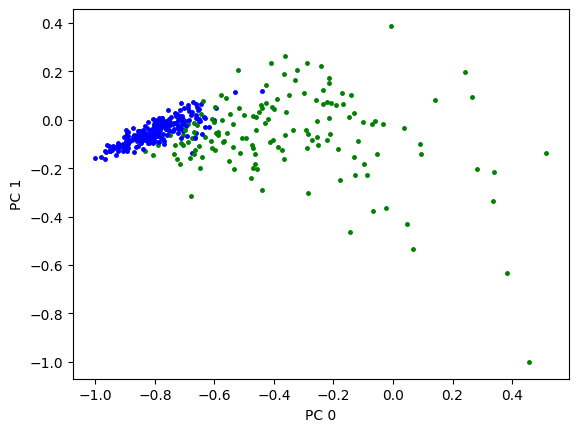

Blue: torch.Size([250])
Green: torch.Size([148])


In [ ]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

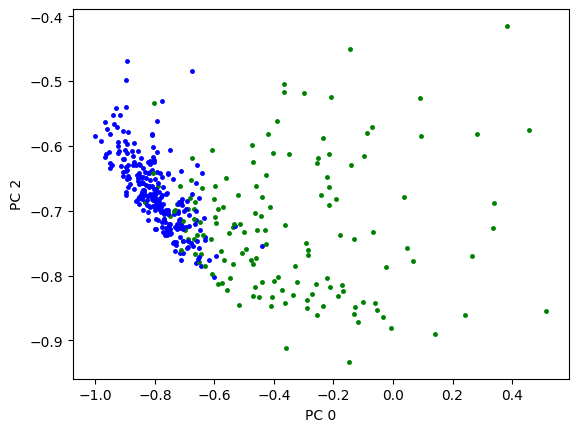

Blue: torch.Size([250])
Green: torch.Size([148])


In [ ]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [ ]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MIN_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)

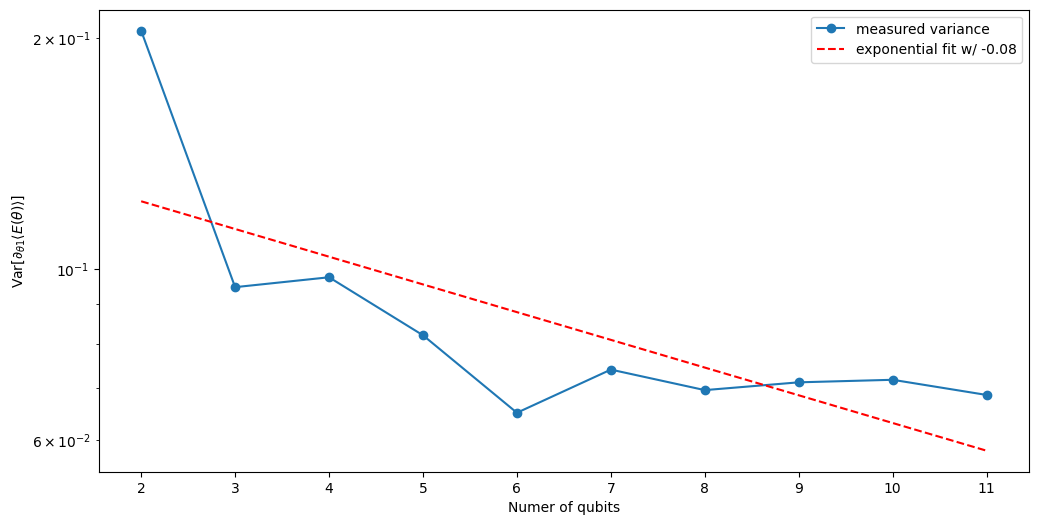

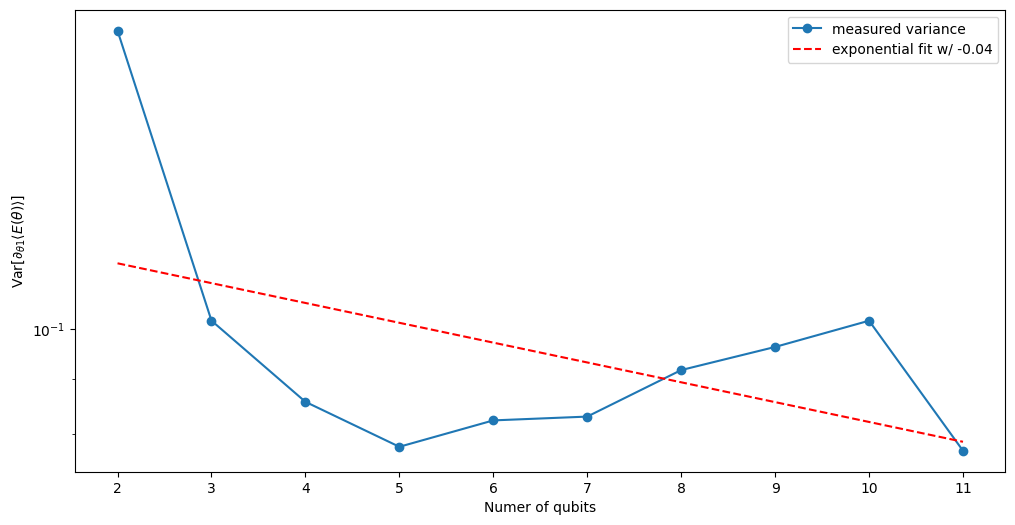

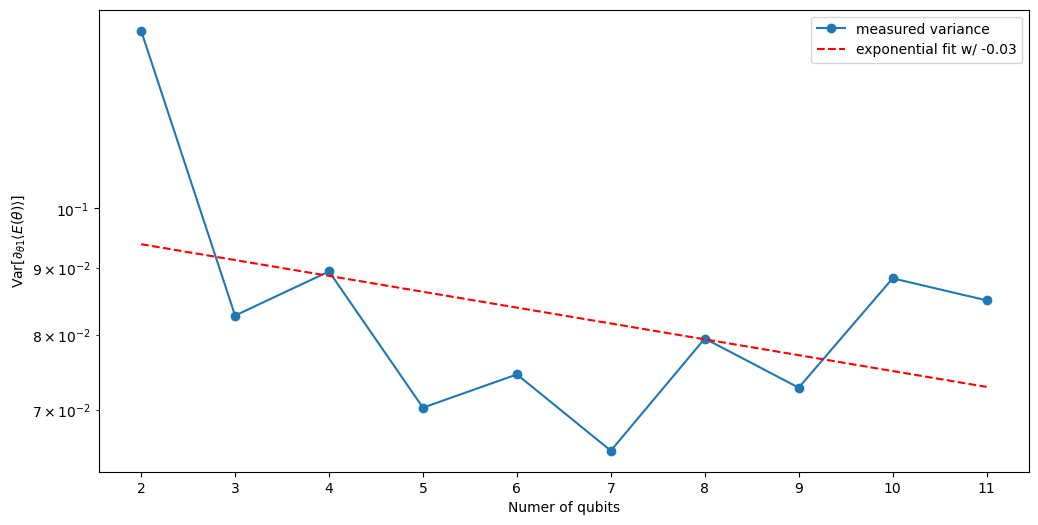

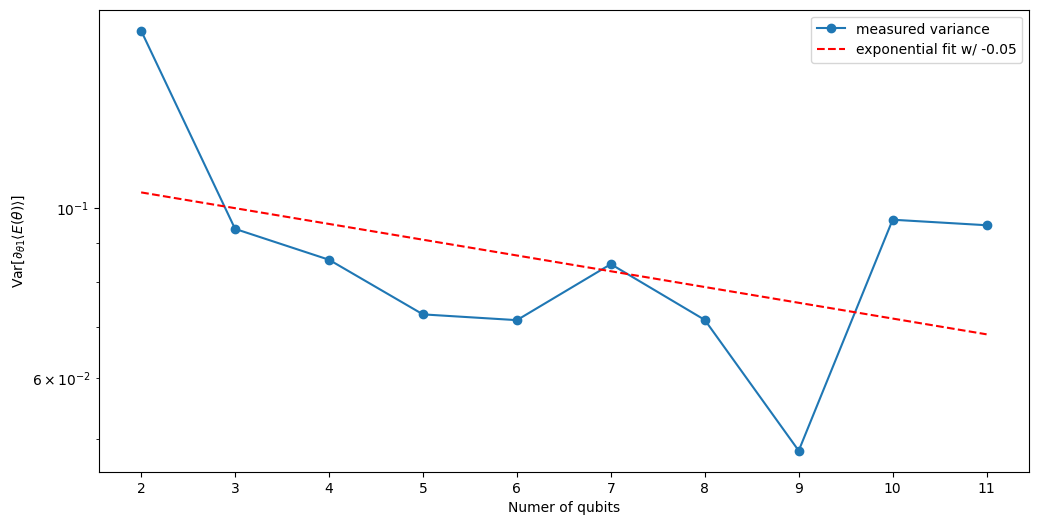

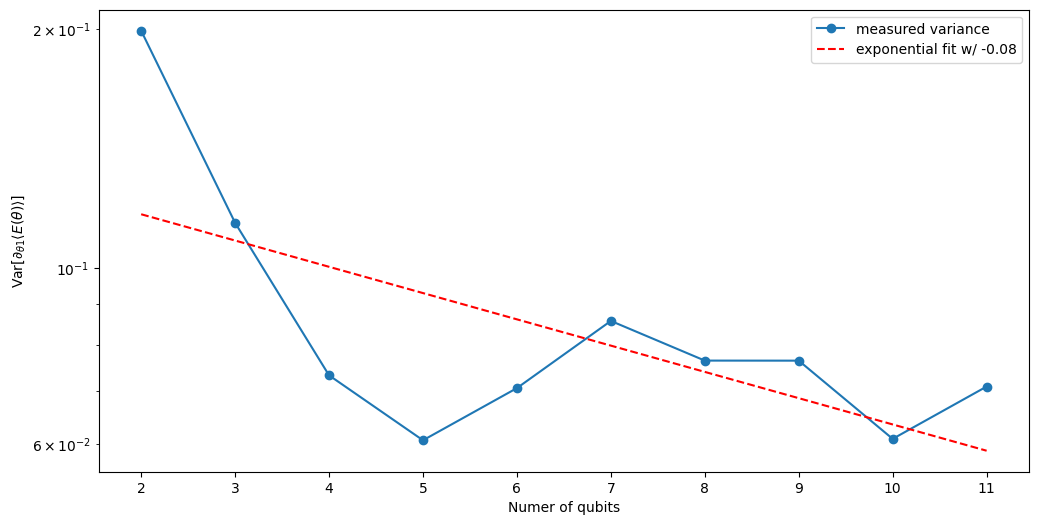

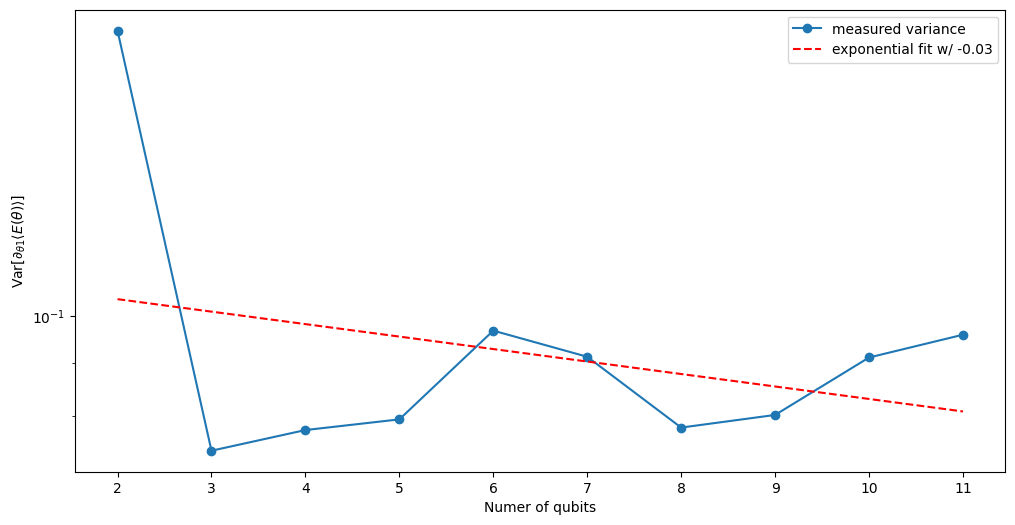

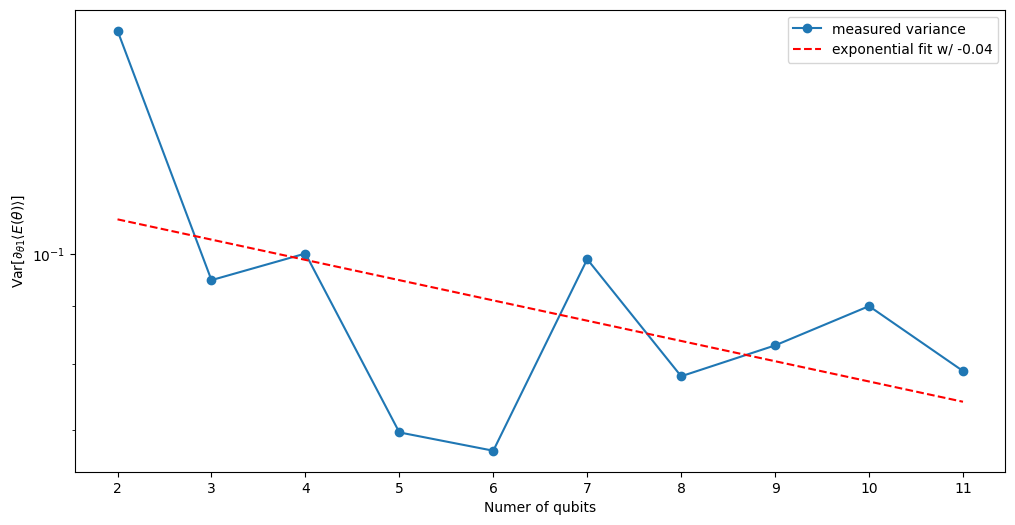

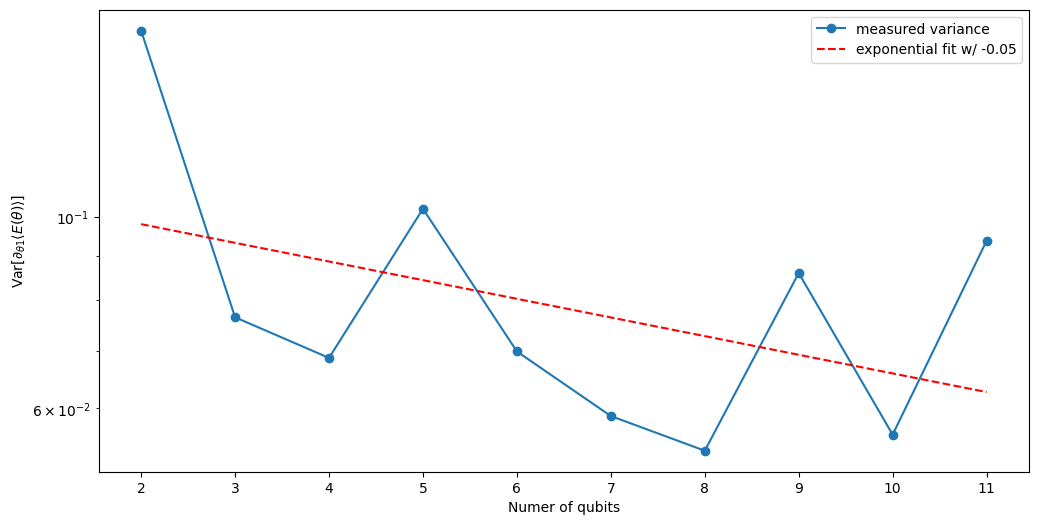

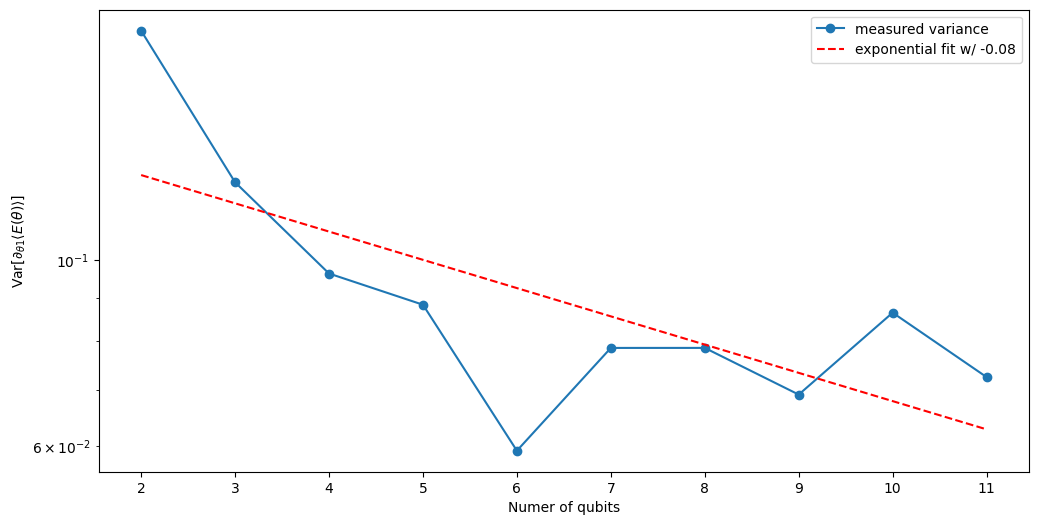

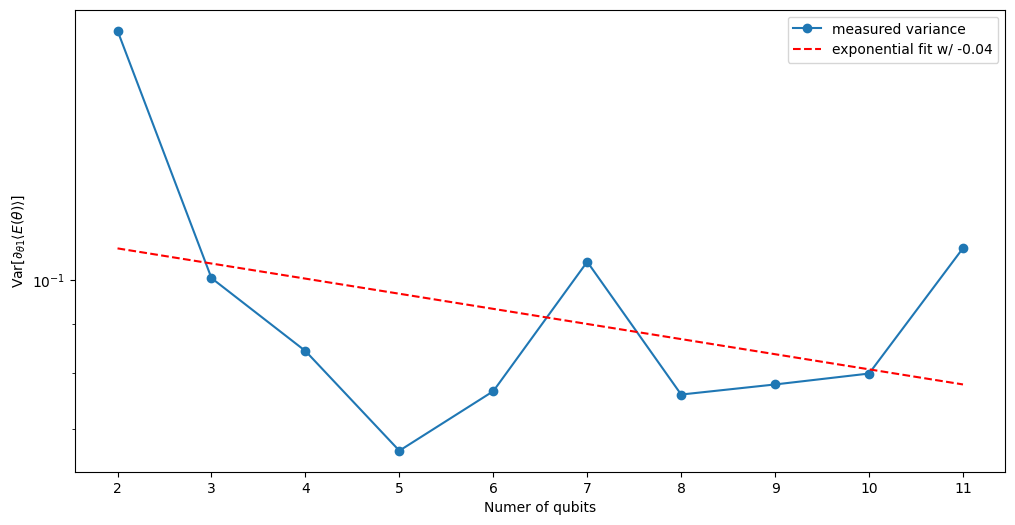

In [ ]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH

for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
# for i in [0]: 
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')

    m1_variances = sampleM1Var()
        
    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=LOCAL_OPERATOR_MIDDLE,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    # initial weights are chosen uniformly at random from [-1, 1]
    model = TorchConnector(qnn)

    loss_function = nn.L1Loss() # nn.MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )

    pd.DataFrame(m1_variances, num_qubits).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Variances.csv')
    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)

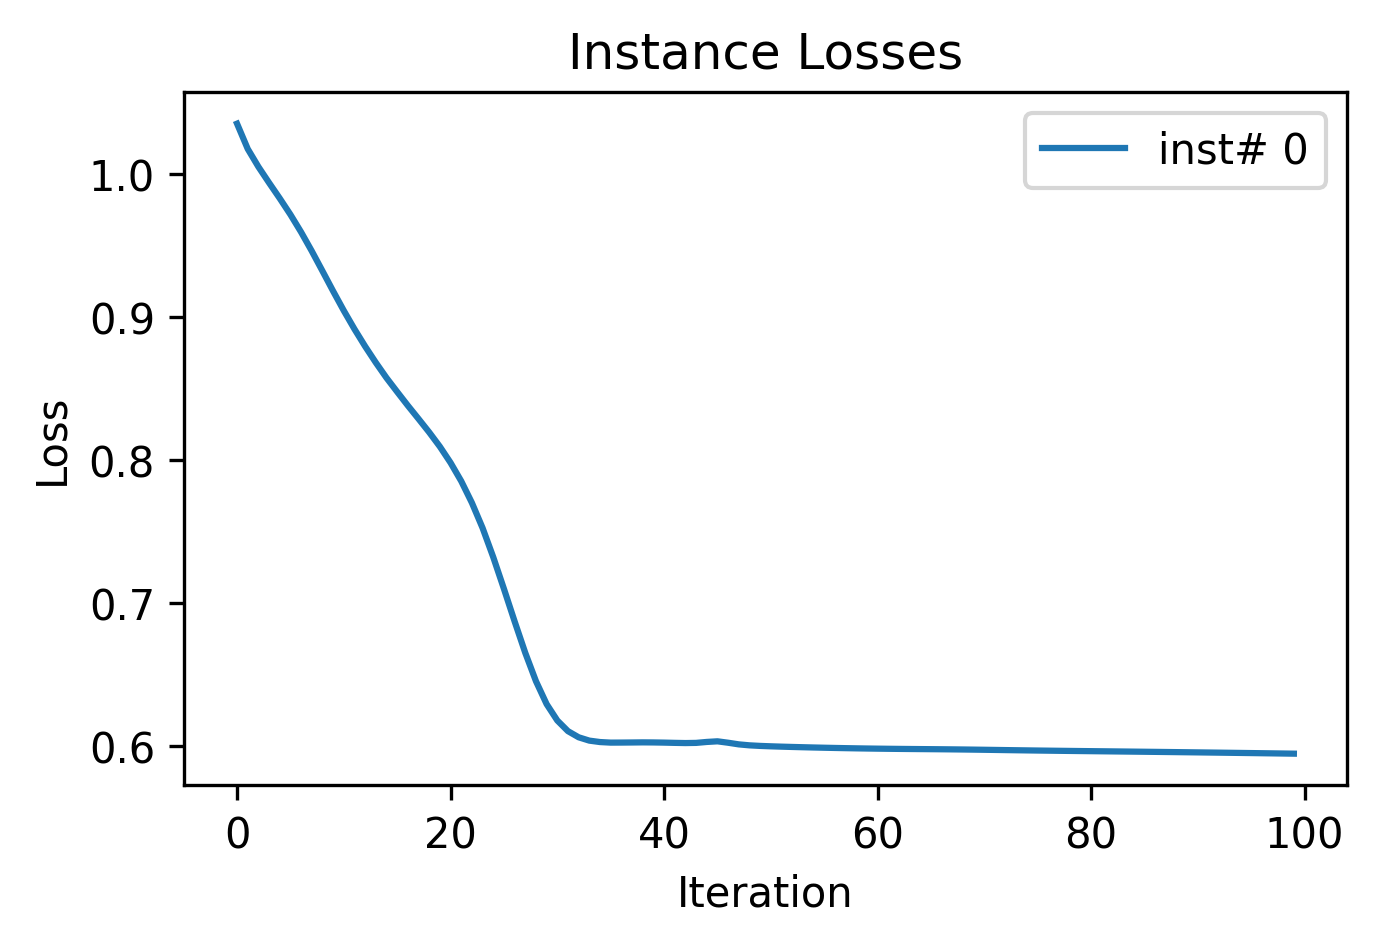

In [ ]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

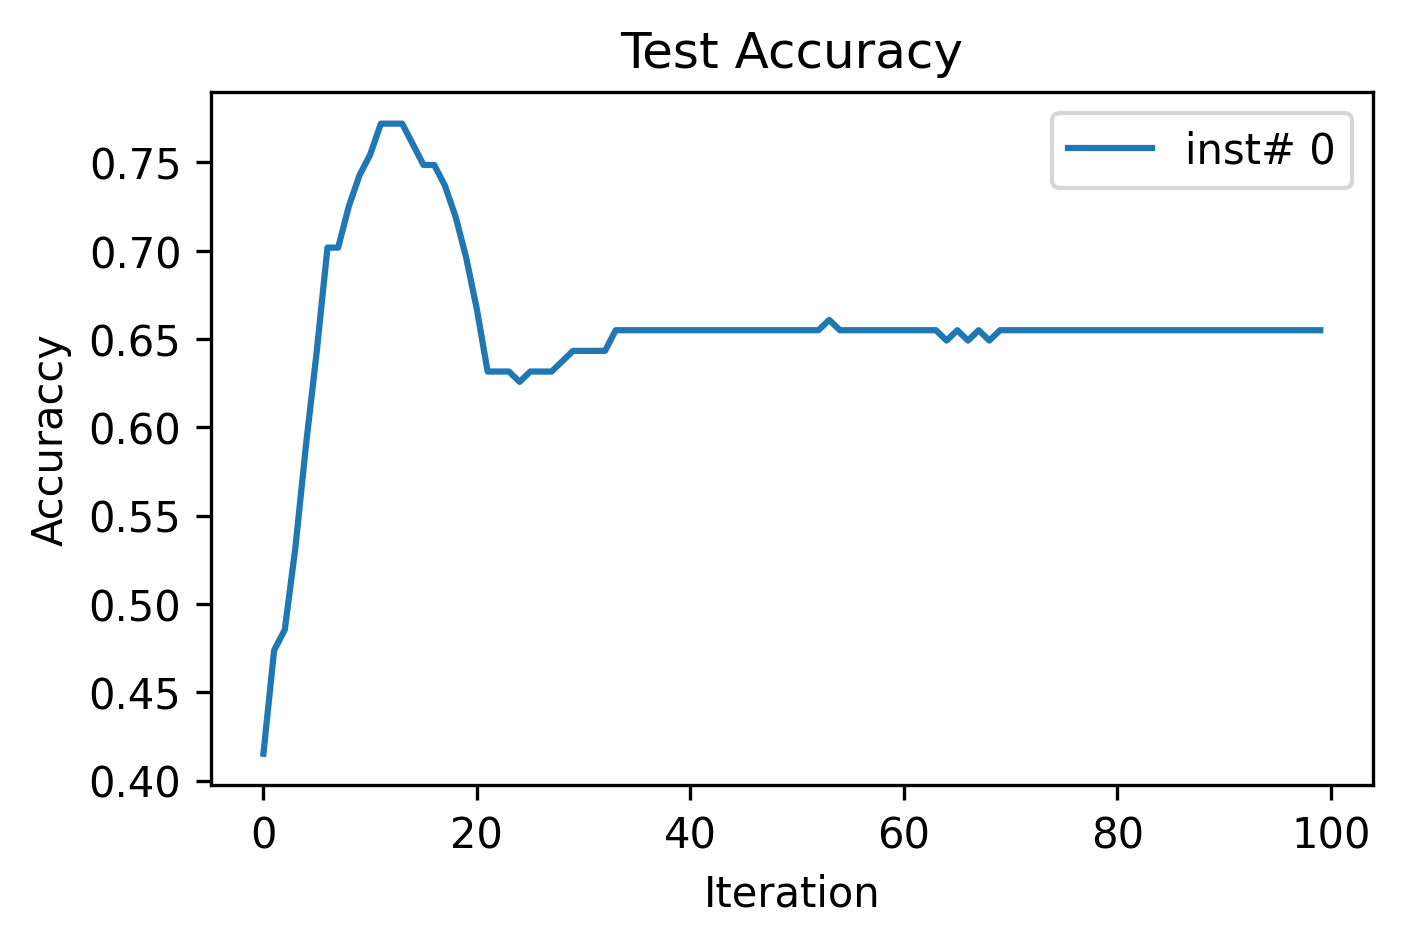

In [ ]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [ ]:
!pip list | grep qiskit

qiskit                    0.45.0
qiskit-aer                0.13.1
qiskit-algorithms         0.2.1
qiskit-ibm-provider       0.7.2
qiskit-ibm-runtime        0.16.1
qiskit-machine-learning   0.7.0
qiskit-terra              0.45.0


In [ ]:
!pip list | grep torch

torch                     1.11.0
torchsummary              1.5.1
torchvision               0.14.1
